In [4]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

import pointpats 
from pointpats import PointPattern
import shapely
from shapely.wkt import loads  
from shapely.geometry import Point
from libpysal.cg import shapely_ext
from pointpats import PoissonPointProcess as ppp_csr
from pointpats import window
from pointpats.window import poly_from_bbox, as_window, Window, to_ccf
import pointpats.quadrat_statistics as qs
from pointpats.centrography import hull, mbr, mean_center, weighted_mean_center, manhattan_median, std_distance,euclidean_median,ellipse
import pysal as ps #derive spatial geometry features 
import libpysal as lps


# to add basemap
!pip install contextily
import contextily
import folium
from folium import plugins
from folium.plugins import HeatMap, MarkerCluster, FastMarkerCluster

from matplotlib import colors
from matplotlib.colors import ListedColormap
from matplotlib.colors import BoundaryNorm
from libpysal import weights
from pysal.explore import esda
from splot import esda as esdaplot  #for an easy way to plot cluster mapb
import numba 

import warnings
warnings.simplefilter('ignore') 

In [5]:
banks_gdf = gpd.read_file("geolytix_uk_banks.shp") #read created shp

In [6]:
banks_gdf.head()

,id,brand_full,brand_shor,branch_nam,branch_typ,add_one,add_two,suburb,town,region,...,hours_thur,hours_frid,hours_satu,trading_ho,status,close_mont,close_year,open_year,po_dist,geometry
0,1,Allied Irish Bank,AIB,Birmingham,Branch,Birmingham City Office,61 Temple Row,Central Birmingham,Birmingham,West Midlands,...,09:00-17:00,09:00-16:45,None,38.75,Open,NaN,NaN,NaN,298,POINT (-1.89857 52.48045)
1,2,Allied Irish Bank,AIB,Brighton,Branch,20/22 Marlborough Place,Brighton,Central Brighton,Brighton,South East,...,09:00-17:00,09:00-16:45,None,38.75,Open,NaN,NaN,NaN,449,POINT (-0.13689 50.82460)
2,3,Allied Irish Bank,AIB,Clifton,Branch,19 Whiteladies Road,Clifton,Cotham,Bristol,South West,...,09:00-17:00,09:00-16:45,None,38.75,Open,NaN,NaN,NaN,511,POINT (-2.60870 51.45976)
3,4,Allied Irish Bank,AIB,High St Belfast,Branch,None,None,Central Belfast,Belfast,Northern Ireland,...,None,None,None,NaN,Closed,8.0,2017.0,NaN,54,POINT (-5.92669 54.59992)
4,5,Allied Irish Bank,AIB,Belfast,Branch,"Donegall Square North, Town Centre, City Of Be...",None,Central Belfast,Belfast,Northern Ireland,...,None,None,None,NaN,Open,NaN,NaN,NaN,166,POINT (-5.93087 54.59725)


In [7]:
#create subset of gdf for branches (branch type)
branches_gdf = banks_gdf[(banks_gdf['branch_typ'] == 'Branch')][['id', 'brand_full', 'brand_shor', 'branch_typ', 'long_wgs84', 'lat_wgs84', 'status', 'close_year', 'geometry']]

In [8]:
branches_gdf

,id,brand_full,brand_shor,branch_typ,long_wgs84,lat_wgs84,status,close_year,geometry
0,1,Allied Irish Bank,AIB,Branch,-1.898570,52.480449,Open,NaN,POINT (-1.89857 52.48045)
1,2,Allied Irish Bank,AIB,Branch,-0.136891,50.824596,Open,NaN,POINT (-0.13689 50.82460)
2,3,Allied Irish Bank,AIB,Branch,-2.608700,51.459759,Open,NaN,POINT (-2.60870 51.45976)
3,4,Allied Irish Bank,AIB,Branch,-5.926691,54.599923,Closed,2017.0,POINT (-5.92669 54.59992)
4,5,Allied Irish Bank,AIB,Branch,-5.930870,54.597250,Open,NaN,POINT (-5.93087 54.59725)
...,...,...,...,...,...,...,...,...,...
11459,11658,Progressive Building Society,PEBS,Branch,-7.301719,54.600146,Open,NaN,POINT (-7.30172 54.60015)
11460,11659,Progressive Building Society,PEBS,Branch,-6.444533,54.422214,Open,NaN,POINT (-6.44453 54.42221)
11461,11660,Progressive Building Society,PEBS,Branch,-7.639917,54.345633,Open,NaN,POINT (-7.63992 54.34563)
11509,11708,Bank of Scotland,BOS,Branch,-3.510956,55.884570,Open,NaN,POINT (-3.51096 55.88457)


In [9]:
# Reproject into BNG 27700
branches_gdf_proj = branches_gdf.to_crs(epsg=27700)

In [10]:
#Read UK boundary shapefile using gpd
UK_LAD_base_pop22 = gpd.read_file('uklad_base_pop22.shp')

In [11]:
UK_LAD_base_pop22 

,LAD24CD,LAD24NM,LAD24NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,estpop_22,estpop22_k,estpop_201,estpop11_k,geometry
0,E06000001,Hartlepool,None,447161,531473,-1.27017,54.6761,3f58aa35-9ea6-4001-a80f-8aab0e41313f,93861,1002,92088,983,"POLYGON ((448964.105 536757.184, 448986.025 53..."
1,E06000002,Middlesbrough,None,451141,516887,-1.21099,54.5447,c5bc1c3e-111f-46db-8e41-362fbbc78d30,148285,2752,138368,2568,"POLYGON ((451894.299 521145.303, 453997.697 51..."
2,E06000003,Redcar and Cleveland,None,464330,519596,-1.00656,54.5675,29afa1cb-8719-44c2-9906-38bc7bae2981,137175,560,135164,552,"POLYGON ((478232.947 518788.803, 477689.303 51..."
3,E06000004,Stockton-on-Tees,None,444940,518179,-1.30664,54.5569,8ebb86c0-86bb-466e-ae7e-a832eeb755ff,199966,976,191824,936,"POLYGON ((452243.536 526335.188, 451711.300 52..."
4,E06000005,Darlington,None,428029,515648,-1.56835,54.5353,bf2173db-02e1-4b58-9617-e775100f58ec,109469,554,105584,535,"POLYGON ((436388.002 522354.197, 437351.702 52..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,W06000020,Torfaen,Torfaen,327459,200480,-3.05101,51.6984,0cf05ad3-d5b4-4034-aef6-391a4f42fdb9,92860,739,91190,725,"POLYGON ((333723.000 192653.903, 331617.797 19..."
357,W06000021,Monmouthshire,Sir Fynwy,337812,209231,-2.90280,51.7783,46cfbd32-dcb3-4da1-a166-0f149baa4e24,93886,111,91508,108,"MULTIPOLYGON (((354639.302 191757.499, 354620...."
358,W06000022,Newport,Casnewydd,337897,187432,-2.89769,51.5823,2d467913-8823-4be7-9178-ced94fc0673a,161506,848,145785,766,"POLYGON ((343091.268 184213.081, 339999.991 18..."
359,W06000023,Powys,Powys,302329,273254,-3.43531,52.3486,1f185fde-3f8c-4e60-b45d-4fb0379a9a51,133891,26,133071,26,"POLYGON ((322891.603 333139.299, 323688.497 33..."


In [12]:
# spatial join 
branches_uklad = gpd.sjoin(branches_gdf_proj, UK_LAD_base_pop22, how='inner', predicate='within') 

# print out the numbers of rows and columns
print("branches_uklad has {0} rows, {1} columns".format(branches_uklad.shape[0], branches_uklad.shape[1]))

branches_uklad has 9866 rows, 22 columns


In [13]:
branches_uklad.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 9866 entries, 0 to 11659
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   id           9866 non-null   int64   
 1   brand_full   9866 non-null   object  
 2   brand_shor   9866 non-null   object  
 3   branch_typ   9866 non-null   object  
 4   long_wgs84   9866 non-null   float64 
 5   lat_wgs84    9866 non-null   float64 
 6   status       9866 non-null   object  
 7   close_year   5638 non-null   float64 
 8   geometry     9866 non-null   geometry
 9   index_right  9866 non-null   int64   
 10  LAD24CD      9866 non-null   object  
 11  LAD24NM      9866 non-null   object  
 12  LAD24NMW     596 non-null    object  
 13  BNG_E        9866 non-null   int64   
 14  BNG_N        9866 non-null   int64   
 15  LONG         9866 non-null   float64 
 16  LAT          9866 non-null   float64 
 17  GlobalID     9866 non-null   object  
 18  estpop_22    9866 non-nu

In [14]:
branches_uklad = branches_uklad[['id', 'brand_full', 'brand_shor', 'status', 'close_year', 'geometry', 'LAD24CD', 'LAD24NM', 'estpop_22']]

In [15]:
# Group by LAD and calculate totals for each status
sums_br_uklad = branches_uklad.groupby("LAD24NM").apply(
    lambda x: pd.Series({
        "total_branches": len(x),
        "closed_branches": (x["status"] == "Closed").sum(),
        "open_branches": (x["status"] == "Open").sum(),
        "closing_branches": (x["status"] == "Closing").sum()
    })
).reset_index()

# Merge the summary back to the LAD boundary GeoDataFrame
sums_br_uklad_base = UK_LAD_base_pop22.merge(sums_br_uklad, left_on="LAD24NM", right_on="LAD24NM", how="left")

In [16]:
sums_br_uklad_base

,LAD24CD,LAD24NM,LAD24NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,estpop_22,estpop22_k,estpop_201,estpop11_k,geometry,total_branches,closed_branches,open_branches,closing_branches
0,E06000001,Hartlepool,None,447161,531473,-1.27017,54.6761,3f58aa35-9ea6-4001-a80f-8aab0e41313f,93861,1002,92088,983,"POLYGON ((448964.105 536757.184, 448986.025 53...",10,4,6,0
1,E06000002,Middlesbrough,None,451141,516887,-1.21099,54.5447,c5bc1c3e-111f-46db-8e41-362fbbc78d30,148285,2752,138368,2568,"POLYGON ((451894.299 521145.303, 453997.697 51...",18,7,11,0
2,E06000003,Redcar and Cleveland,None,464330,519596,-1.00656,54.5675,29afa1cb-8719-44c2-9906-38bc7bae2981,137175,560,135164,552,"POLYGON ((478232.947 518788.803, 477689.303 51...",19,14,5,0
3,E06000004,Stockton-on-Tees,None,444940,518179,-1.30664,54.5569,8ebb86c0-86bb-466e-ae7e-a832eeb755ff,199966,976,191824,936,"POLYGON ((452243.536 526335.188, 451711.300 52...",27,12,15,0
4,E06000005,Darlington,None,428029,515648,-1.56835,54.5353,bf2173db-02e1-4b58-9617-e775100f58ec,109469,554,105584,535,"POLYGON ((436388.002 522354.197, 437351.702 52...",14,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,W06000020,Torfaen,Torfaen,327459,200480,-3.05101,51.6984,0cf05ad3-d5b4-4034-aef6-391a4f42fdb9,92860,739,91190,725,"POLYGON ((333723.000 192653.903, 331617.797 19...",17,6,11,0
357,W06000021,Monmouthshire,Sir Fynwy,337812,209231,-2.90280,51.7783,46cfbd32-dcb3-4da1-a166-0f149baa4e24,93886,111,91508,108,"MULTIPOLYGON (((354639.302 191757.499, 354620....",30,15,15,0
358,W06000022,Newport,Casnewydd,337897,187432,-2.89769,51.5823,2d467913-8823-4be7-9178-ced94fc0673a,161506,848,145785,766,"POLYGON ((343091.268 184213.081, 339999.991 18...",19,6,13,0
359,W06000023,Powys,Powys,302329,273254,-3.43531,52.3486,1f185fde-3f8c-4e60-b45d-4fb0379a9a51,133891,26,133071,26,"POLYGON ((322891.603 333139.299, 323688.497 33...",46,33,13,0


In [17]:
#create series proportion closed branches 
sums_br_uklad_base["clbr_prop"] = (sums_br_uklad_base["closed_branches"] / sums_br_uklad_base["total_branches"])

#save to file
sums_br_uklad_base.to_file(driver='ESRI Shapefile', filename='sums_br_uklad_base.shp')

In [18]:
sums_br_uklad_base

,LAD24CD,LAD24NM,LAD24NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,estpop_22,estpop22_k,estpop_201,estpop11_k,geometry,total_branches,closed_branches,open_branches,closing_branches,clbr_prop
0,E06000001,Hartlepool,None,447161,531473,-1.27017,54.6761,3f58aa35-9ea6-4001-a80f-8aab0e41313f,93861,1002,92088,983,"POLYGON ((448964.105 536757.184, 448986.025 53...",10,4,6,0,0.400000
1,E06000002,Middlesbrough,None,451141,516887,-1.21099,54.5447,c5bc1c3e-111f-46db-8e41-362fbbc78d30,148285,2752,138368,2568,"POLYGON ((451894.299 521145.303, 453997.697 51...",18,7,11,0,0.388889
2,E06000003,Redcar and Cleveland,None,464330,519596,-1.00656,54.5675,29afa1cb-8719-44c2-9906-38bc7bae2981,137175,560,135164,552,"POLYGON ((478232.947 518788.803, 477689.303 51...",19,14,5,0,0.736842
3,E06000004,Stockton-on-Tees,None,444940,518179,-1.30664,54.5569,8ebb86c0-86bb-466e-ae7e-a832eeb755ff,199966,976,191824,936,"POLYGON ((452243.536 526335.188, 451711.300 52...",27,12,15,0,0.444444
4,E06000005,Darlington,None,428029,515648,-1.56835,54.5353,bf2173db-02e1-4b58-9617-e775100f58ec,109469,554,105584,535,"POLYGON ((436388.002 522354.197, 437351.702 52...",14,3,11,0,0.214286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,W06000020,Torfaen,Torfaen,327459,200480,-3.05101,51.6984,0cf05ad3-d5b4-4034-aef6-391a4f42fdb9,92860,739,91190,725,"POLYGON ((333723.000 192653.903, 331617.797 19...",17,6,11,0,0.352941
357,W06000021,Monmouthshire,Sir Fynwy,337812,209231,-2.90280,51.7783,46cfbd32-dcb3-4da1-a166-0f149baa4e24,93886,111,91508,108,"MULTIPOLYGON (((354639.302 191757.499, 354620....",30,15,15,0,0.500000
358,W06000022,Newport,Casnewydd,337897,187432,-2.89769,51.5823,2d467913-8823-4be7-9178-ced94fc0673a,161506,848,145785,766,"POLYGON ((343091.268 184213.081, 339999.991 18...",19,6,13,0,0.315789
359,W06000023,Powys,Powys,302329,273254,-3.43531,52.3486,1f185fde-3f8c-4e60-b45d-4fb0379a9a51,133891,26,133071,26,"POLYGON ((322891.603 333139.299, 323688.497 33...",46,33,13,0,0.717391


In [19]:
branch_lad = sums_br_uklad_base.loc[:, ['LAD24CD','LAD24NM', 'total_branches', 'closed_branches', 'open_branches', 'closing_branches', 'clbr_prop','geometry']]
print(branch_lad.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 361 entries, 0 to 360
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   LAD24CD           361 non-null    object  
 1   LAD24NM           361 non-null    object  
 2   total_branches    361 non-null    int64   
 3   closed_branches   361 non-null    int64   
 4   open_branches     361 non-null    int64   
 5   closing_branches  361 non-null    int64   
 6   clbr_prop         361 non-null    float64 
 7   geometry          361 non-null    geometry
dtypes: float64(1), geometry(1), int64(4), object(2)
memory usage: 22.7+ KB
None


In [20]:
branch_lad_geo = branch_lad.to_crs(epsg=4326)

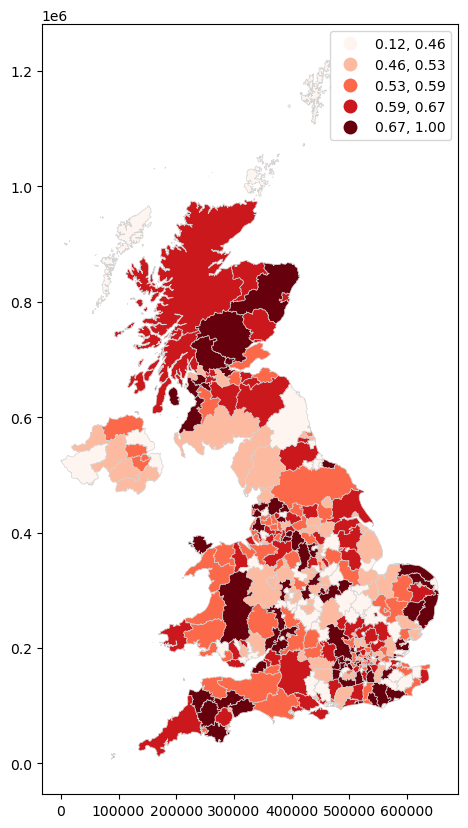

In [21]:
fig, ax = plt.subplots(1, figsize=(10,10))
branch_lad.plot(column='clbr_prop', cmap='Reds', 
        scheme='quantiles', legend=True,
        edgecolor="lightgrey", linewidth=0.5, ax=ax)
plt.show()

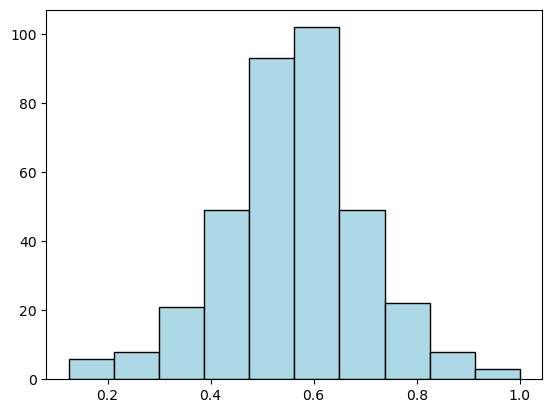

In [22]:
plt.hist(branch_lad['clbr_prop'], bins=10, facecolor='lightblue', edgecolor='black')
plt.show()

In [23]:
#quantiles scheme suitable for choropleth as normally distributed data

**Global Spatial Autocorrelation**

<Axes: >

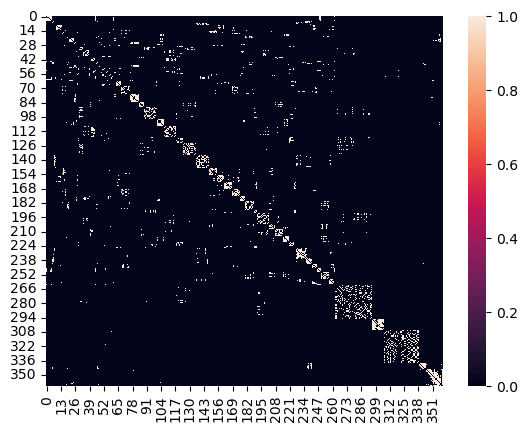

In [24]:
#create a spatial weights matrix

branchKNN8 = weights.KNN.from_dataframe(branch_lad, k=8, ids=branch_lad['LAD24NM'].tolist())
branchKNN8mat = pd.DataFrame(branchKNN8.full()[0])  #convert the matrix to a pandas df
sns.heatmap(branchKNN8mat)

In [25]:
#check 
branchKNN8['Monmouthshire']

{'Torfaen': 1.0,
 'Newport': 1.0,
 'Blaenau Gwent': 1.0,
 'Caerphilly': 1.0,
 'Forest of Dean': 1.0,
 'Merthyr Tydfil': 1.0,
 'Cardiff': 1.0,
 'South Gloucestershire': 1.0}

In [26]:
# Row standardize the matrix
branchKNN8.transform = 'R'

In [27]:
#calculate Global Moran's I
np.random.seed(10) #for replicable results
moran_clbrpropKNN8 = esda.moran.Moran(branch_lad['clbr_prop'], branchKNN8)
round(moran_clbrpropKNN8.I,3) #print moran's I value rounded to 3 dp

0.069

In [28]:
moran_clbrpropKNN8.p_sim #pseudo p-value

0.003

In [29]:
#the value of 0.057 is much smaller than 0.3 - indicating no global spatial autocorrelation

**LISA**

In [30]:
#calculate spatial lag for closed branch proportion
branch_lad['clbrprop_lag'] = weights.spatial_lag.lag_spatial(branchKNN8, branch_lad['clbr_prop'])

In [31]:
#standardise by calculating z-score
def standardize(df, var):
    
    newname = var + '_z'
    df[newname] = (df[var] - df[var].mean()) / df[var].std()

standardize(branch_lad,'clbr_prop')
standardize(branch_lad,'clbrprop_lag')

In [32]:
branch_lad.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 361 entries, 0 to 360
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   LAD24CD           361 non-null    object  
 1   LAD24NM           361 non-null    object  
 2   total_branches    361 non-null    int64   
 3   closed_branches   361 non-null    int64   
 4   open_branches     361 non-null    int64   
 5   closing_branches  361 non-null    int64   
 6   clbr_prop         361 non-null    float64 
 7   geometry          361 non-null    geometry
 8   clbrprop_lag      361 non-null    float64 
 9   clbr_prop_z       361 non-null    float64 
 10  clbrprop_lag_z    361 non-null    float64 
dtypes: float64(4), geometry(1), int64(4), object(2)
memory usage: 31.2+ KB


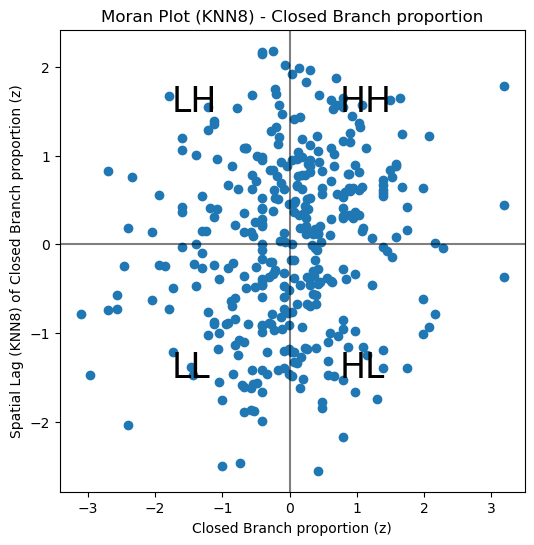

In [33]:
#create Moran plot

fig, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
plt.scatter(branch_lad['clbr_prop_z'], branch_lad['clbrprop_lag_z'])
# Add vertical and horizontal lines through zero
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
# Add text labels for each quadrant
plt.text(0.75, 1.5, "HH", fontsize=25)
plt.text(0.75, -1.5, "HL", fontsize=25)
plt.text(-1.75, 1.5, "LH", fontsize=25)
plt.text(-1.75, -1.5, "LL", fontsize=25)
# Display
ax.set_title('Moran Plot (KNN8) - Closed Branch proportion')
ax.set_xlabel("Closed Branch proportion (z)")
ax.set_ylabel("Spatial Lag (KNN8) of Closed Branch proportion (z)")
plt.show()

In [34]:
#calculate Local Moran's I

lisa_branchKNN8 = esda.moran.Moran_Local(branch_lad['clbr_prop'], branchKNN8, seed=10)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

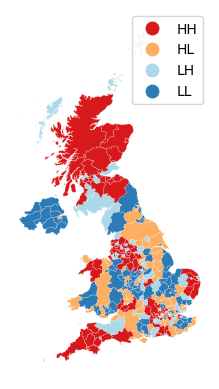

In [35]:
#cluster map - p=1

esdaplot.lisa_cluster(lisa_branchKNN8, branch_lad, p=1)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

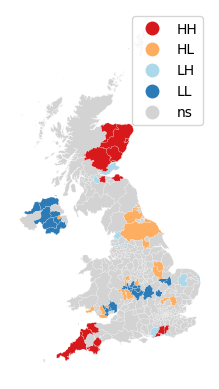

In [36]:
#cluster map - p=0.05

esdaplot.lisa_cluster(lisa_branchKNN8, branch_lad, p=0.05)

In [37]:
#adjusting p-value threshold

lisa_branchKNN8_fdr95 = esda.fdr(pvalues=lisa_branchKNN8.p_sim, alpha=0.05)
lisa_branchKNN8_fdr95

0.00013850415512465375

(<Figure size 640x480 with 1 Axes>, <Axes: >)

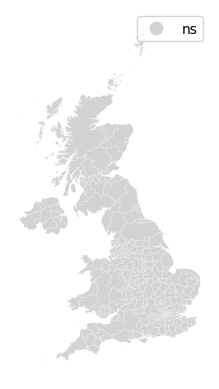

In [38]:
#cluster map with adjusted threshold
esdaplot.lisa_cluster(lisa_branchKNN8, branch_lad, p=lisa_branchKNN8_fdr95)

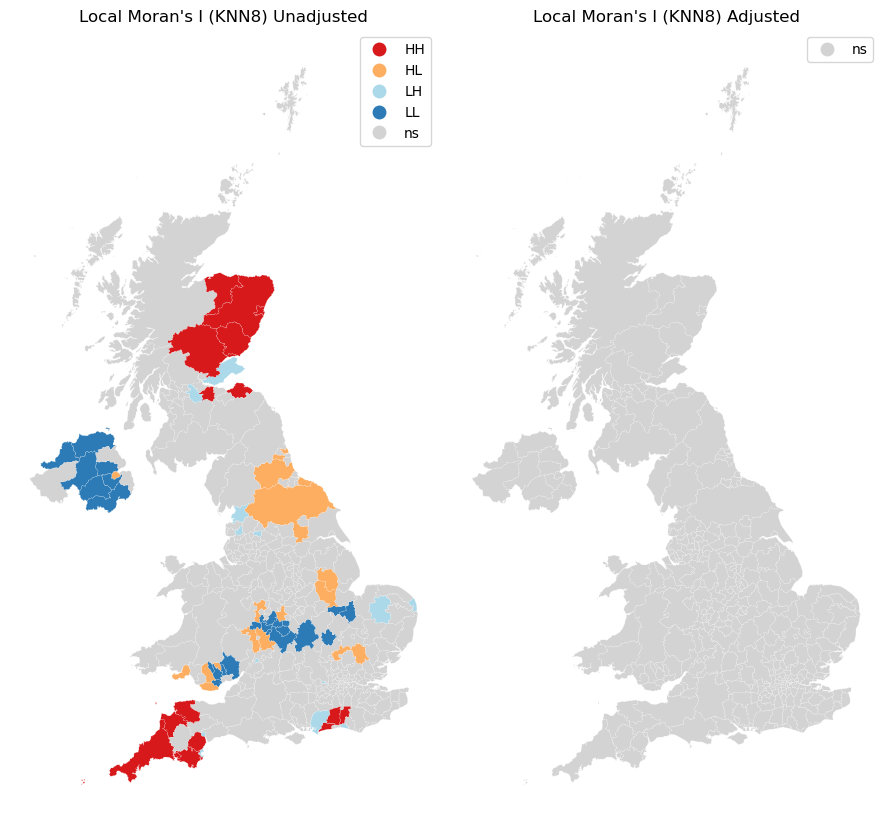

In [88]:
fig, axs1 = plt.subplots(1,2, figsize=(9, 9))

esdaplot.lisa_cluster(lisa_branchKNN8, branch_lad, p=0.05, ax=axs1[0])
axs1[0].set_title("Local Moran's I (KNN8) Unadjusted")

esdaplot.lisa_cluster(lisa_branchKNN8, branch_lad, p=lisa_branchKNN8_fdr95, ax=axs1[1])
axs1[1].set_title("Local Moran's I (KNN8) Adjusted")

fig.tight_layout()

#save as file
plt.savefig("figures/lisamaps_clbr.png", dpi=300, bbox_inches='tight', facecolor='white')

plt.show()

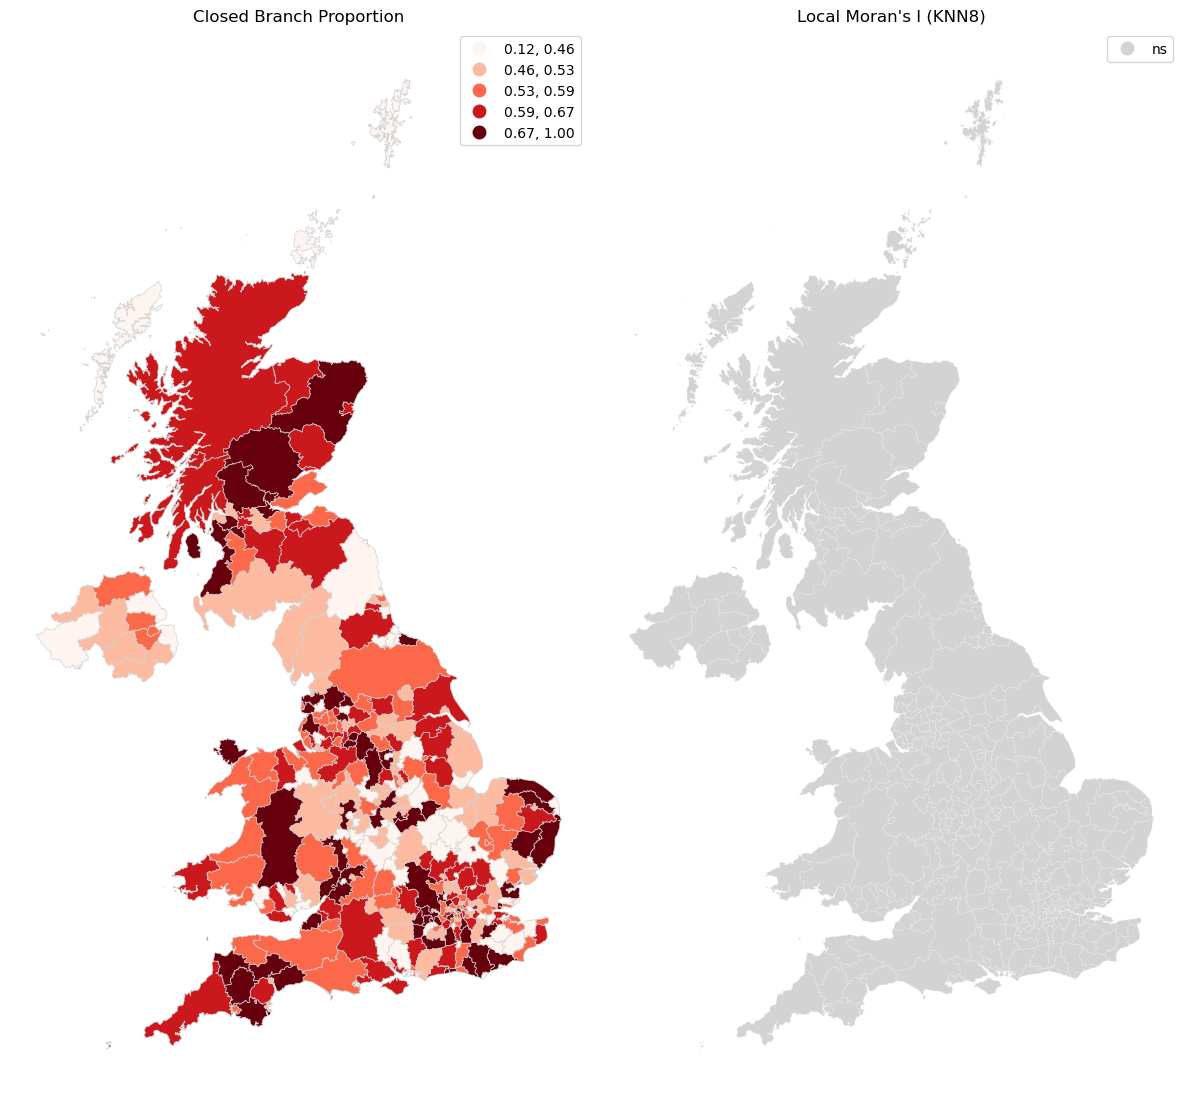

In [42]:
fig, axs = plt.subplots(1,2, figsize=(12, 12))

branch_lad.plot(ax=axs[0], column='clbr_prop', cmap='Reds', 
        scheme='quantiles', legend=True,
       edgecolor="lightgrey", linewidth=0.5)
axs[0].set_axis_off()
axs[0].set_title("Closed Branch Proportion")

esdaplot.lisa_cluster(lisa_branchKNN8, branch_lad, p=lisa_branchKNN8_fdr95, ax=axs[1])
axs[1].set_title("Local Moran's I (KNN8)")

fig.tight_layout()
plt.show()

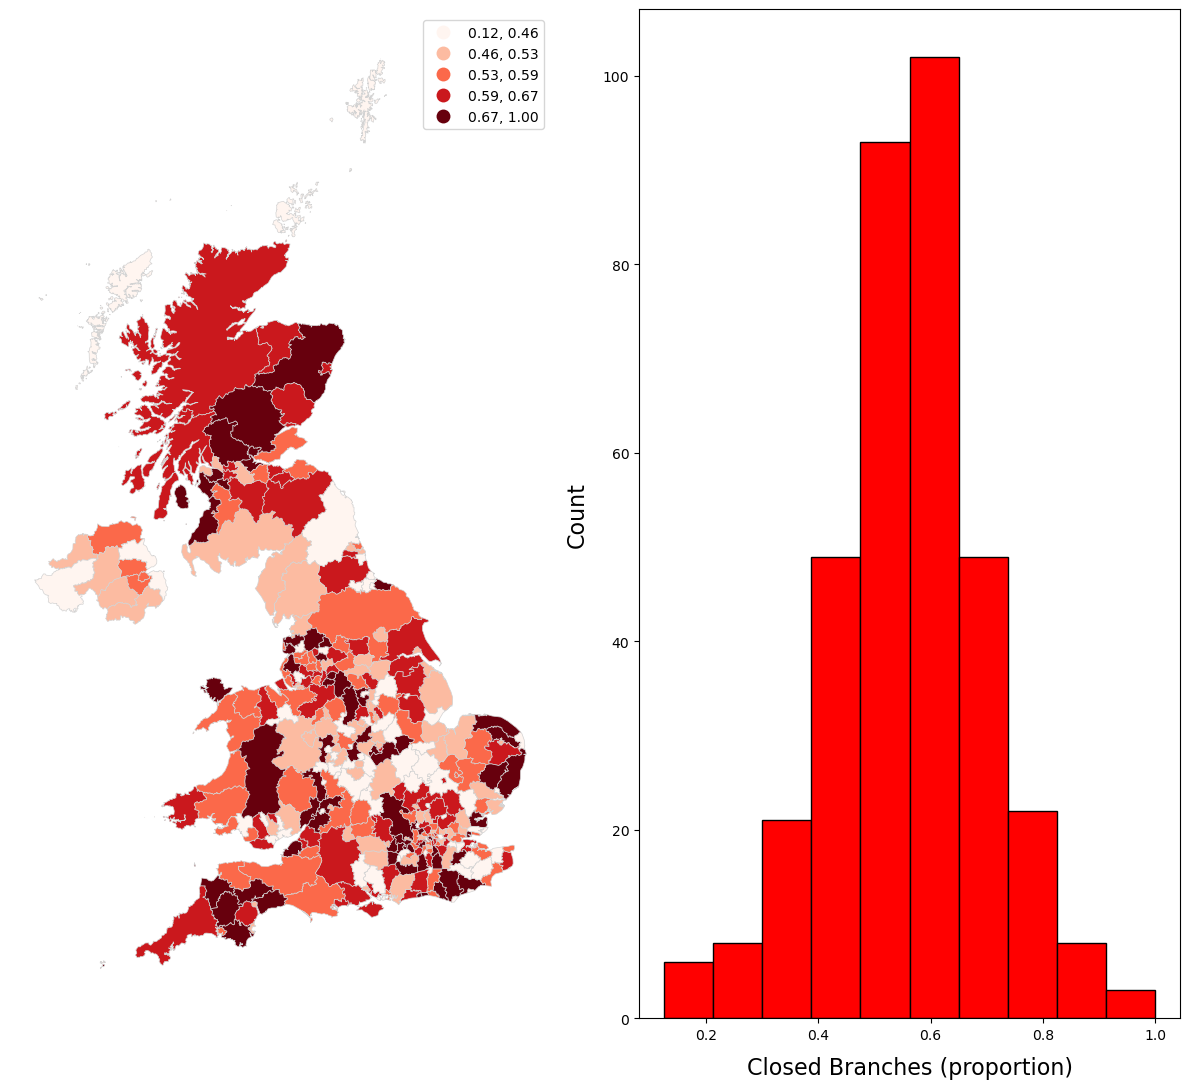

In [110]:
fig, axs2 = plt.subplots(1,2, figsize=(12, 11))

branch_lad.plot(ax=axs2[0], column='clbr_prop', cmap='Reds', 
        scheme='quantiles', legend=True,
       edgecolor="lightgrey", linewidth=0.5)
axs2[0].set_axis_off()
#axs2[0].set_title("Closed Branch Proportion")

branch_lad['clbr_prop'].hist(bins=10, 
         facecolor='red', edgecolor='black', grid=False, ax=axs2[1])

axs2[1].set_xlabel("Closed Branches (proportion)",labelpad=10, fontsize=16)  
axs2[1].set_ylabel("Count",labelpad=10, fontsize=16)  
#axs2[1].set_title("Proportion of Branches Closed")
#save as file
plt.savefig("figures/maphist_clbr.png", dpi=300, bbox_inches='tight', facecolor='white')

fig.tight_layout()
plt.show()

**LADs with highest, lowest, median stats for: closed branches proportions; 2022 est. pop; and LISA**

In [43]:
branch_lad[branch_lad['clbr_prop'] == branch_lad['clbr_prop'].min()]

,LAD24CD,LAD24NM,total_branches,closed_branches,open_branches,closing_branches,clbr_prop,geometry,clbrprop_lag,clbr_prop_z,clbrprop_lag_z
155,E07000136,Boston,8,1,7,0,0.125,"POLYGON ((547581.870 350621.038, 544447.600 34...",0.50674,-3.104874,-0.788101


In [44]:
branch_lad[branch_lad['clbr_prop'] == branch_lad['clbr_prop'].max()]

,LAD24CD,LAD24NM,total_branches,closed_branches,open_branches,closing_branches,clbr_prop,geometry,clbrprop_lag,clbr_prop_z,clbrprop_lag_z
49,E06000053,Isles of Scilly,1,1,0,0,1.0,"MULTIPOLYGON (((87801.360 8851.282, 89245.064 ...",0.662056,3.18479,1.781208
148,E07000129,Blaby,6,6,0,0,1.0,"POLYGON ((455201.096 307300.695, 454863.403 30...",0.531885,3.18479,-0.372142
208,E07000223,Adur,11,11,0,0,1.0,"POLYGON ((523604.003 108612.299, 525682.251 10...",0.581491,3.18479,0.448466


In [45]:
branch_lad[branch_lad['clbr_prop'] == branch_lad['clbr_prop'].median()]

,LAD24CD,LAD24NM,total_branches,closed_branches,open_branches,closing_branches,clbr_prop,geometry,clbrprop_lag,clbr_prop_z,clbrprop_lag_z
25,E06000026,Plymouth,32,18,14,0,0.5625,"MULTIPOLYGON (((245726.716 60484.541, 245476.8...",0.670597,0.039958,1.922501
31,E06000034,Thurrock,16,9,7,0,0.5625,"MULTIPOLYGON (((576891.628 182723.873, 576944....",0.554782,0.039958,0.006624
174,E07000175,Newark and Sherwood,16,9,7,0,0.5625,"POLYGON ((489087.803 372235.298, 488512.899 36...",0.480641,0.039958,-1.219840
226,E07000245,West Suffolk,32,18,14,0,0.5625,"POLYGON ((602112.296 278815.799, 601201.730 27...",0.508069,0.039958,-0.766112
298,N09000003,Belfast,48,27,20,1,0.5625,"POLYGON ((147602.683 535143.997, 147602.595 53...",0.464935,0.039958,-1.479657


In [46]:
UK_LAD_base_pop22 [UK_LAD_base_pop22 ['estpop_22'] == UK_LAD_base_pop22['estpop_22'].min()]

,LAD24CD,LAD24NM,LAD24NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,estpop_22,estpop22_k,estpop_201,estpop11_k,geometry
49,E06000053,Isles of Scilly,None,91327,11447,-6.30217,49.9233,10015513-fa6a-47ac-a7a5-80167adb5366,2281,140,2224,136,"MULTIPOLYGON (((87801.360 8851.282, 89245.064 ..."


In [47]:
UK_LAD_base_pop22 [UK_LAD_base_pop22 ['estpop_22'] == UK_LAD_base_pop22 ['estpop_22'].max()]

,LAD24CD,LAD24NM,LAD24NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,estpop_22,estpop22_k,estpop_201,estpop11_k,geometry
250,E08000025,Birmingham,None,408150,287352,-1.88141,52.484,d5084175-2117-4a56-81a1-0848348903d1,1157603,4323,1074283,4012,"POLYGON ((414459.338 298918.633, 416118.350 29..."


In [48]:
UK_LAD_base_pop22 [UK_LAD_base_pop22 ['estpop_22'] == UK_LAD_base_pop22 ['estpop_22'].median()]

,LAD24CD,LAD24NM,LAD24NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,estpop_22,estpop22_k,estpop_201,estpop11_k,geometry
350,W06000013,Bridgend,Pen-y-bont ar Ogwr,288231,185870,-3.61375,51.5606,57144f6a-cb25-4614-88a3-cb07704e2600,146136,583,139410,556,"POLYGON ((296179.502 180365.100, 293926.102 17..."


In [49]:
branch_lad[branch_lad['closed_branches'] == branch_lad['closed_branches'].max()]

,LAD24CD,LAD24NM,total_branches,closed_branches,open_branches,closing_branches,clbr_prop,geometry,clbrprop_lag,clbr_prop_z,clbrprop_lag_z
61,E06000065,North Yorkshire,148,86,59,3,0.581081,"POLYGON ((516811.854 475020.058, 515766.998 47...",0.477543,0.173522,-1.271091


In [50]:
branch_lad[branch_lad['closed_branches'] == branch_lad['closed_branches'].min()]

,LAD24CD,LAD24NM,total_branches,closed_branches,open_branches,closing_branches,clbr_prop,geometry,clbrprop_lag,clbr_prop_z,clbrprop_lag_z
49,E06000053,Isles of Scilly,1,1,0,0,1.000000,"MULTIPOLYGON (((87801.360 8851.282, 89245.064 ...",0.662056,3.184790,1.781208
69,E07000033,Bolsover,2,1,1,0,0.500000,"POLYGON ((452887.673 369248.523, 453760.100 36...",0.571553,-0.409304,0.284057
155,E07000136,Boston,8,1,7,0,0.125000,"POLYGON ((547581.870 350621.038, 544447.600 34...",0.506740,-3.104874,-0.788101
360,W06000024,Merthyr Tydfil,7,1,6,0,0.142857,"POLYGON ((308057.304 211036.201, 308367.104 20...",0.465482,-2.976514,-1.470611


HH: North Devon; Arun

HL: Powys; County Durham; North Yorkshire

LH: Chichester; Brighton & Hove; Great Yarmouth; Lancaster

LL: Cardiff; Stratford-on-Avon; West Northamptonshire; Bedford; Warwick; Dudley; Birmingham; Coventry

Mean center: East Staffordshire

Weighted Mean center: Doveridge

**Analysis by year**

In [51]:
# change 'close_year' column to integer type; replace NaN with a placeholder 
branches_uklad['close_year'] = branches_uklad['close_year'].fillna(0).astype(int)

In [52]:
branches_uklad

,id,brand_full,brand_shor,status,close_year,geometry,LAD24CD,LAD24NM,estpop_22
0,1,Allied Irish Bank,AIB,Open,0,POINT (406985.628 286951.900),E08000025,Birmingham,1157603
1,2,Allied Irish Bank,AIB,Open,0,POINT (531321.460 104437.756),E06000043,Brighton and Hove,277965
2,3,Allied Irish Bank,AIB,Open,0,POINT (357806.814 173596.202),E06000023,"Bristol, City of",479024
3,4,Allied Irish Bank,AIB,Closed,2017,POINT (146477.883 529839.203),N09000003,Belfast,348005
4,5,Allied Irish Bank,AIB,Open,0,POINT (146191.459 529557.099),N09000003,Belfast,348005
...,...,...,...,...,...,...,...,...,...
11459,11658,Progressive Building Society,PEBS,Open,0,POINT (57741.257 535702.312),N09000006,Fermanagh and Omagh,116994
11460,11659,Progressive Building Society,PEBS,Open,0,POINT (111801.658 512078.472),N09000002,"Armagh City, Banbridge and Craigavon",220271
11461,11660,Progressive Building Society,PEBS,Open,0,POINT (33652.296 509130.058),N09000006,Fermanagh and Omagh,116994
11509,11708,Bank of Scotland,BOS,Open,0,POINT (305583.977 666745.954),S12000040,West Lothian,181720


2017-18

In [53]:
# Filter for specific years 2017 and 2018 - closed branches only
clbr_2017_18 = branches_uklad[branches_uklad['close_year'].isin([2017, 2018])]

# Total branches by LAD
total_branches = branches_uklad.groupby('LAD24NM').size().reset_index(name='total_branches')

# Closed branches by LAD for 2017 and 2018
sums_clbr_2017_18 = clbr_2017_18.groupby('LAD24NM').size().reset_index(name='closed_branches')

In [54]:
# Merge total and closed branches
clbr_prop_2017_18 = pd.merge(total_branches, sums_clbr_2017_18, on='LAD24NM', how='left')

# Fill NaN for LADs with no closed branches in 2017 and 2018
clbr_prop_2017_18['closed_branches'] = clbr_prop_2017_18['closed_branches'].fillna(0)

# Calculate the proportion of closed branches
clbr_prop_2017_18['clbr_prop'] = clbr_prop_2017_18['closed_branches'] / clbr_prop_2017_18['total_branches']

# Display the result
print(clbr_prop_2017_18)

           LAD24NM  total_branches  closed_branches  clbr_prop
0    Aberdeen City              47              5.0   0.106383
1    Aberdeenshire              51             12.0   0.235294
2             Adur              11              1.0   0.090909
3     Amber Valley              21              4.0   0.190476
4            Angus              28              5.0   0.178571
..             ...             ...              ...        ...
356        Wrexham              16              1.0   0.062500
357       Wychavon              19              4.0   0.210526
358           Wyre              26              6.0   0.230769
359    Wyre Forest              12              2.0   0.166667
360           York              27              3.0   0.111111

[361 rows x 4 columns]


In [55]:
# Merge proportions with LAD GeoDataFrame
clbr_ladprop_2017_18 = UK_LAD_base_pop22.merge(clbr_prop_2017_18, on='LAD24NM', how='left')

In [56]:
clbr_ladprop_2017_18

,LAD24CD,LAD24NM,LAD24NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,estpop_22,estpop22_k,estpop_201,estpop11_k,geometry,total_branches,closed_branches,clbr_prop
0,E06000001,Hartlepool,None,447161,531473,-1.27017,54.6761,3f58aa35-9ea6-4001-a80f-8aab0e41313f,93861,1002,92088,983,"POLYGON ((448964.105 536757.184, 448986.025 53...",10,0.0,0.000000
1,E06000002,Middlesbrough,None,451141,516887,-1.21099,54.5447,c5bc1c3e-111f-46db-8e41-362fbbc78d30,148285,2752,138368,2568,"POLYGON ((451894.299 521145.303, 453997.697 51...",18,4.0,0.222222
2,E06000003,Redcar and Cleveland,None,464330,519596,-1.00656,54.5675,29afa1cb-8719-44c2-9906-38bc7bae2981,137175,560,135164,552,"POLYGON ((478232.947 518788.803, 477689.303 51...",19,4.0,0.210526
3,E06000004,Stockton-on-Tees,None,444940,518179,-1.30664,54.5569,8ebb86c0-86bb-466e-ae7e-a832eeb755ff,199966,976,191824,936,"POLYGON ((452243.536 526335.188, 451711.300 52...",27,4.0,0.148148
4,E06000005,Darlington,None,428029,515648,-1.56835,54.5353,bf2173db-02e1-4b58-9617-e775100f58ec,109469,554,105584,535,"POLYGON ((436388.002 522354.197, 437351.702 52...",14,1.0,0.071429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,W06000020,Torfaen,Torfaen,327459,200480,-3.05101,51.6984,0cf05ad3-d5b4-4034-aef6-391a4f42fdb9,92860,739,91190,725,"POLYGON ((333723.000 192653.903, 331617.797 19...",17,2.0,0.117647
357,W06000021,Monmouthshire,Sir Fynwy,337812,209231,-2.90280,51.7783,46cfbd32-dcb3-4da1-a166-0f149baa4e24,93886,111,91508,108,"MULTIPOLYGON (((354639.302 191757.499, 354620....",30,4.0,0.133333
358,W06000022,Newport,Casnewydd,337897,187432,-2.89769,51.5823,2d467913-8823-4be7-9178-ced94fc0673a,161506,848,145785,766,"POLYGON ((343091.268 184213.081, 339999.991 18...",19,1.0,0.052632
359,W06000023,Powys,Powys,302329,273254,-3.43531,52.3486,1f185fde-3f8c-4e60-b45d-4fb0379a9a51,133891,26,133071,26,"POLYGON ((322891.603 333139.299, 323688.497 33...",46,14.0,0.304348


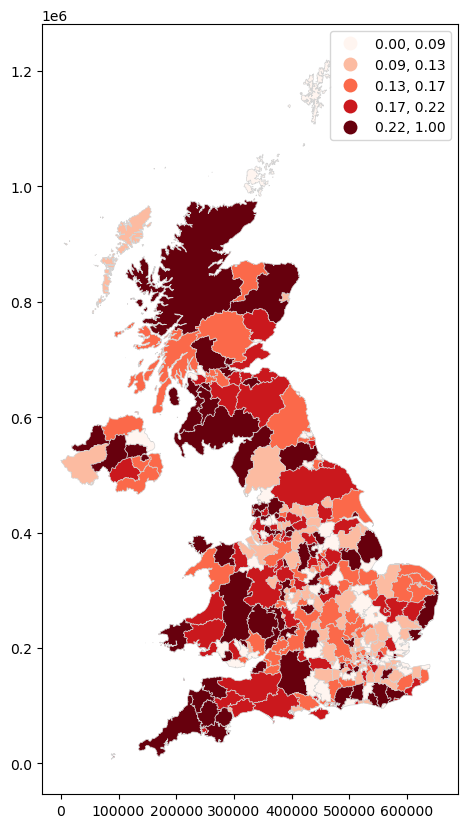

In [57]:
fig, ax17_18 = plt.subplots(1, figsize=(10,10))
clbr_ladprop_2017_18.plot(column='clbr_prop', cmap='Reds', 
        scheme='quantiles', legend=True,
        edgecolor="lightgrey", linewidth=0.5, ax=ax17_18)
plt.show()

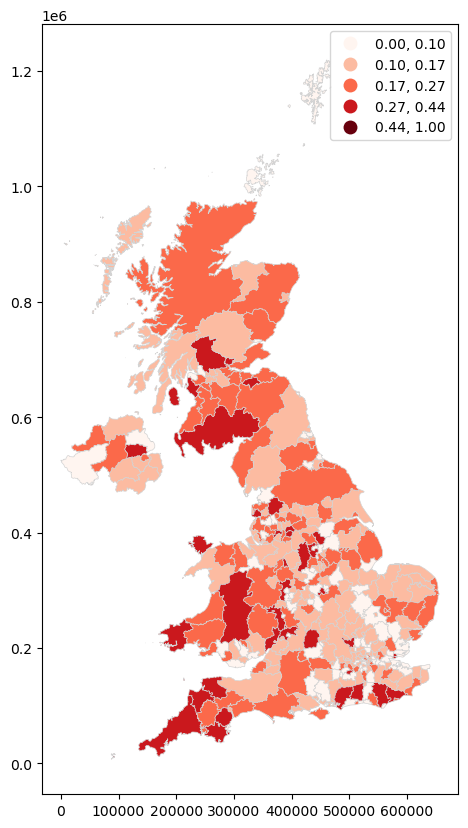

In [58]:
fig, ax17_18 = plt.subplots(1, figsize=(10,10))
clbr_ladprop_2017_18.plot(column='clbr_prop', cmap='Reds', 
        scheme='fisher_jenks', legend=True,
        edgecolor="lightgrey", linewidth=0.5, ax=ax17_18)
plt.show()

<Axes: >

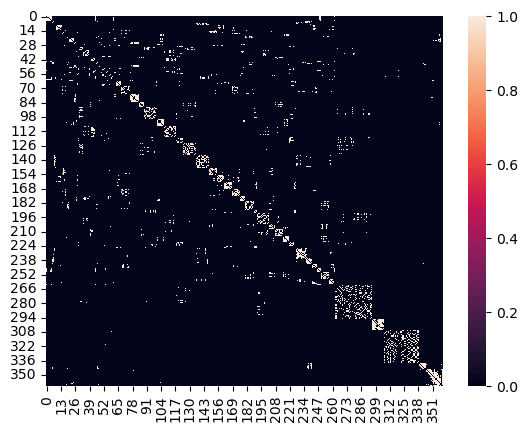

In [59]:
#create a spatial weights matrix
clbr1718KNN8 = weights.KNN.from_dataframe(clbr_ladprop_2017_18, k=8, ids=clbr_ladprop_2017_18['LAD24NM'].tolist())
clbr1718KNN8mat = pd.DataFrame(clbr1718KNN8.full()[0])  #convert the matrix to a pandas df
sns.heatmap(clbr1718KNN8mat)

In [60]:
# Row standardize the matrix
clbr1718KNN8.transform = 'R'

In [61]:
#calculate Global Moran's I
np.random.seed(10) #for replicable results
moran_clbrprop1718KNN8 = esda.moran.Moran(clbr_ladprop_2017_18['clbr_prop'], clbr1718KNN8)
round(moran_clbrprop1718KNN8.I,3) #print moran's I value rounded to 3 dp

0.103

In [62]:
moran_clbrprop1718KNN8.p_sim #pseudo p-value

0.002

In [63]:
#calculate spatial lag for closed branch proportion
clbr_ladprop_2017_18['clbrprop_lag'] = weights.spatial_lag.lag_spatial(clbr1718KNN8, clbr_ladprop_2017_18['clbr_prop'])

In [64]:
#standardise by calculating z-score
def standardize(df, var):
    
    newname = var + '_z'
    df[newname] = (df[var] - df[var].mean()) / df[var].std()

standardize(clbr_ladprop_2017_18,'clbr_prop')
standardize(clbr_ladprop_2017_18,'clbrprop_lag')

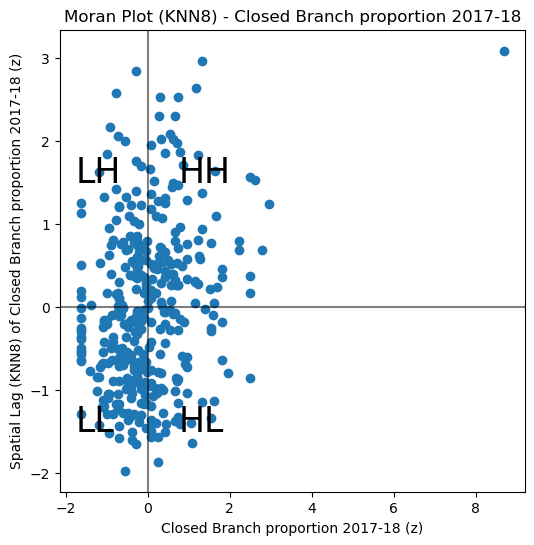

In [65]:
#create Moran plot

fig, ax1718 = plt.subplots(1, figsize=(6, 6))
# Plot values
plt.scatter(clbr_ladprop_2017_18['clbr_prop_z'], clbr_ladprop_2017_18['clbrprop_lag_z'])
# Add vertical and horizontal lines through zero
ax1718.axvline(0, c='k', alpha=0.5)
ax1718.axhline(0, c='k', alpha=0.5)
# Add text labels for each quadrant
plt.text(0.75, 1.5, "HH", fontsize=25)
plt.text(0.75, -1.5, "HL", fontsize=25)
plt.text(-1.75, 1.5, "LH", fontsize=25)
plt.text(-1.75, -1.5, "LL", fontsize=25)
# Display
ax1718.set_title('Moran Plot (KNN8) - Closed Branch proportion 2017-18')
ax1718.set_xlabel("Closed Branch proportion 2017-18 (z)")
ax1718.set_ylabel("Spatial Lag (KNN8) of Closed Branch proportion 2017-18 (z)")
plt.show()

In [66]:
#calculate Local Moran's I

lisa_clbrprop1718KNN8 = esda.moran.Moran_Local(clbr_ladprop_2017_18['clbr_prop'], clbr1718KNN8, seed=10)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

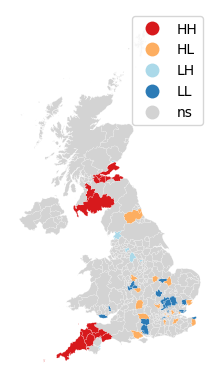

In [67]:
#cluster map - p=0.05

esdaplot.lisa_cluster(lisa_clbrprop1718KNN8, clbr_ladprop_2017_18, p=0.05)

In [68]:
#adjusting p-value threshold

lisa_clbrprop1718KNN8_fdr95 = esda.fdr(pvalues=lisa_clbrprop1718KNN8.p_sim, alpha=0.05)
lisa_clbrprop1718KNN8_fdr95

0.00013850415512465375

(<Figure size 640x480 with 1 Axes>, <Axes: >)

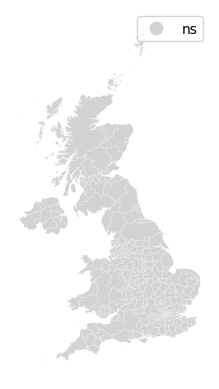

In [69]:
#cluster map with adjusted threshold
esdaplot.lisa_cluster(lisa_clbrprop1718KNN8, clbr_ladprop_2017_18, p=lisa_clbrprop1718KNN8_fdr95)

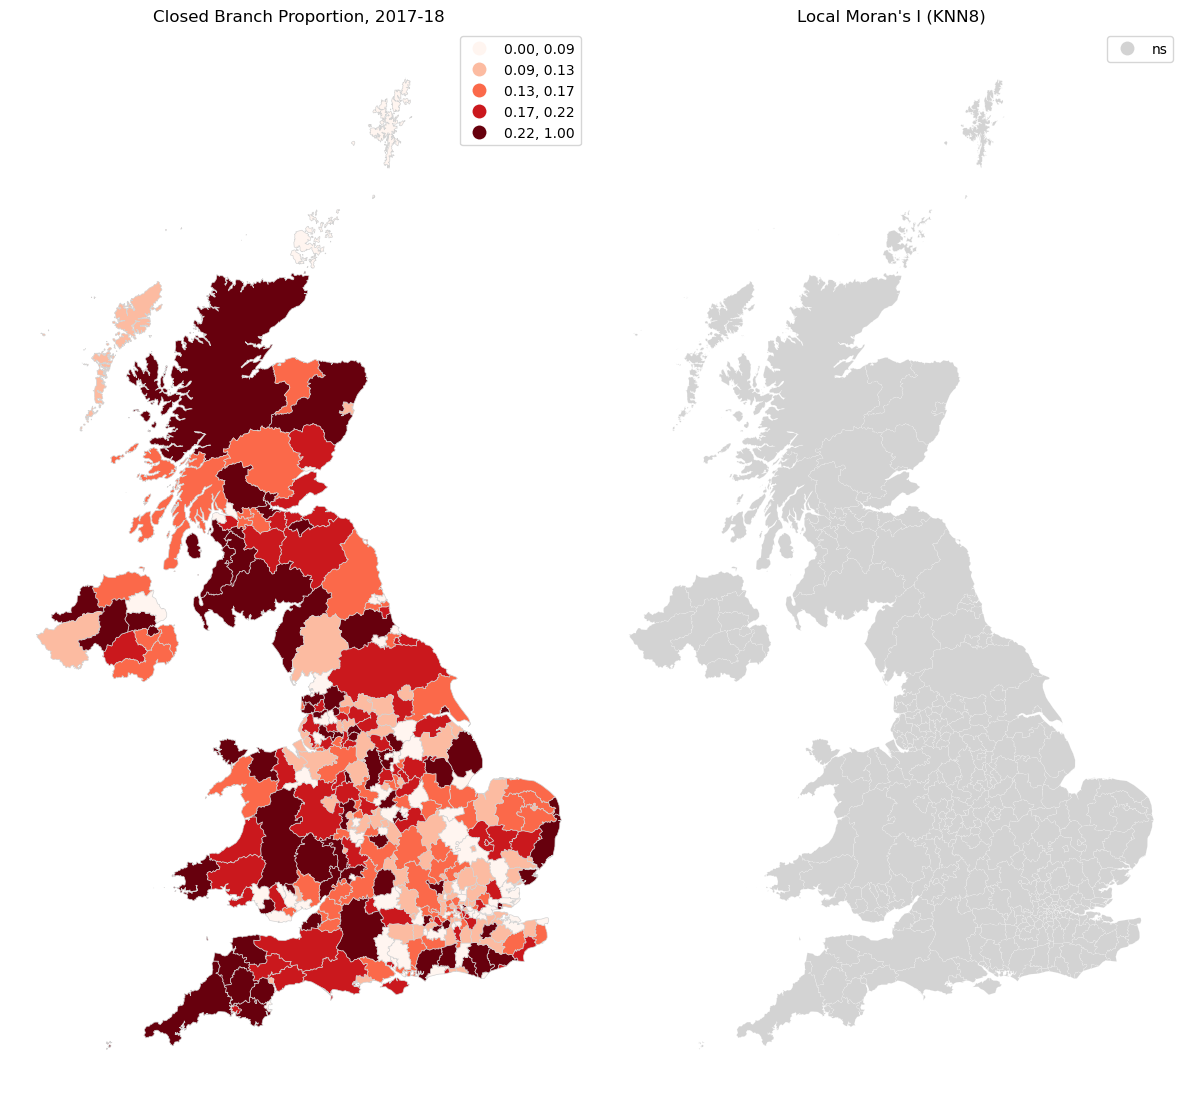

In [70]:
#your code here
fig, ax2 = plt.subplots(1,2, figsize=(12, 12))

clbr_ladprop_2017_18.plot(ax=ax2[0], column='clbr_prop', cmap='Reds', 
        scheme='quantiles', legend=True,
       edgecolor="lightgrey", linewidth=0.5)
ax2[0].set_axis_off()
ax2[0].set_title("Closed Branch Proportion, 2017-18")

esdaplot.lisa_cluster(lisa_clbrprop1718KNN8, clbr_ladprop_2017_18, p=lisa_clbrprop1718KNN8_fdr95, ax=ax2[1])

ax2[1].set_title("Local Moran's I (KNN8)")

fig.tight_layout()
plt.show()

2022-23

In [71]:
# Filter for specific years 2022 and 2023 - closed branches only
clbr_2022_23 = branches_uklad[branches_uklad['close_year'].isin([2022, 2023])]

# Total branches by LAD - as above
#total_branches = branches_uklad.groupby('LAD24NM').size().reset_index(name='total_branches')

# Closed branches by LAD for 2022 and 2023
sums_clbr_2022_23 = clbr_2022_23.groupby('LAD24NM').size().reset_index(name='closed_branches')

In [72]:
# Merge total and closed branches
clbr_prop_2022_23 = pd.merge(total_branches, sums_clbr_2022_23, on='LAD24NM', how='left')

# Fill NaN for LADs with no closed branches in 2022 and 2023
clbr_prop_2022_23['closed_branches'] = clbr_prop_2022_23['closed_branches'].fillna(0)

# Calculate the proportion of closed branches
clbr_prop_2022_23['clbr_prop'] = clbr_prop_2022_23['closed_branches'] / clbr_prop_2022_23['total_branches']

# Display the result
print(clbr_prop_2022_23)

           LAD24NM  total_branches  closed_branches  clbr_prop
0    Aberdeen City              47              8.0   0.170213
1    Aberdeenshire              51              9.0   0.176471
2             Adur              11              1.0   0.090909
3     Amber Valley              21              3.0   0.142857
4            Angus              28              3.0   0.107143
..             ...             ...              ...        ...
356        Wrexham              16              1.0   0.062500
357       Wychavon              19              2.0   0.105263
358           Wyre              26              2.0   0.076923
359    Wyre Forest              12              1.0   0.083333
360           York              27              4.0   0.148148

[361 rows x 4 columns]


In [73]:
# Merge proportions with LAD GeoDataFrame
clbr_ladprop_2022_23 = UK_LAD_base_pop22.merge(clbr_prop_2022_23, on='LAD24NM', how='left')

In [74]:
clbr_ladprop_2022_23

,LAD24CD,LAD24NM,LAD24NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,estpop_22,estpop22_k,estpop_201,estpop11_k,geometry,total_branches,closed_branches,clbr_prop
0,E06000001,Hartlepool,None,447161,531473,-1.27017,54.6761,3f58aa35-9ea6-4001-a80f-8aab0e41313f,93861,1002,92088,983,"POLYGON ((448964.105 536757.184, 448986.025 53...",10,2.0,0.200000
1,E06000002,Middlesbrough,None,451141,516887,-1.21099,54.5447,c5bc1c3e-111f-46db-8e41-362fbbc78d30,148285,2752,138368,2568,"POLYGON ((451894.299 521145.303, 453997.697 51...",18,1.0,0.055556
2,E06000003,Redcar and Cleveland,None,464330,519596,-1.00656,54.5675,29afa1cb-8719-44c2-9906-38bc7bae2981,137175,560,135164,552,"POLYGON ((478232.947 518788.803, 477689.303 51...",19,5.0,0.263158
3,E06000004,Stockton-on-Tees,None,444940,518179,-1.30664,54.5569,8ebb86c0-86bb-466e-ae7e-a832eeb755ff,199966,976,191824,936,"POLYGON ((452243.536 526335.188, 451711.300 52...",27,2.0,0.074074
4,E06000005,Darlington,None,428029,515648,-1.56835,54.5353,bf2173db-02e1-4b58-9617-e775100f58ec,109469,554,105584,535,"POLYGON ((436388.002 522354.197, 437351.702 52...",14,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,W06000020,Torfaen,Torfaen,327459,200480,-3.05101,51.6984,0cf05ad3-d5b4-4034-aef6-391a4f42fdb9,92860,739,91190,725,"POLYGON ((333723.000 192653.903, 331617.797 19...",17,2.0,0.117647
357,W06000021,Monmouthshire,Sir Fynwy,337812,209231,-2.90280,51.7783,46cfbd32-dcb3-4da1-a166-0f149baa4e24,93886,111,91508,108,"MULTIPOLYGON (((354639.302 191757.499, 354620....",30,4.0,0.133333
358,W06000022,Newport,Casnewydd,337897,187432,-2.89769,51.5823,2d467913-8823-4be7-9178-ced94fc0673a,161506,848,145785,766,"POLYGON ((343091.268 184213.081, 339999.991 18...",19,0.0,0.000000
359,W06000023,Powys,Powys,302329,273254,-3.43531,52.3486,1f185fde-3f8c-4e60-b45d-4fb0379a9a51,133891,26,133071,26,"POLYGON ((322891.603 333139.299, 323688.497 33...",46,7.0,0.152174


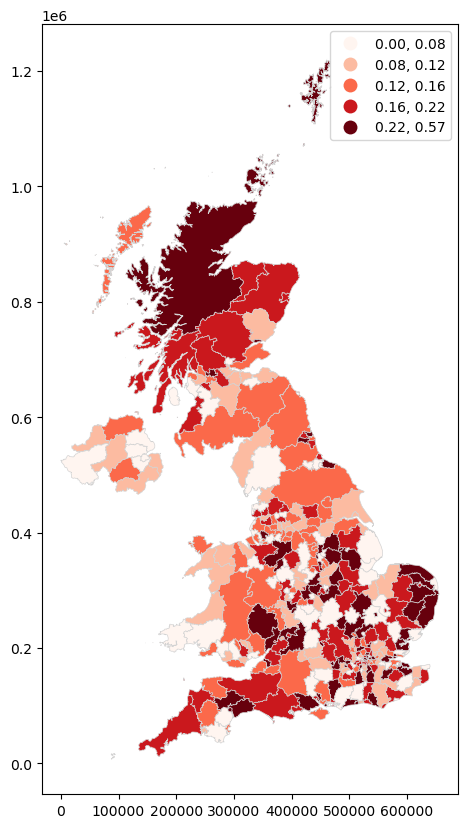

In [75]:
fig, ax22_23 = plt.subplots(1, figsize=(10,10))
clbr_ladprop_2022_23.plot(column='clbr_prop', cmap='Reds', 
        scheme='quantiles', legend=True,
        edgecolor="lightgrey", linewidth=0.5, ax=ax22_23)
plt.show()

<Axes: >

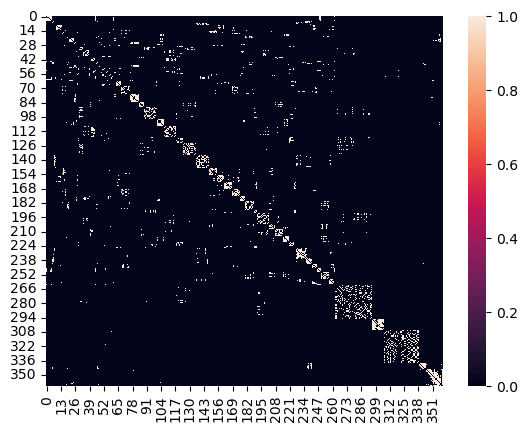

In [76]:
#create a spatial weights matrix
clbr2223KNN8 = weights.KNN.from_dataframe(clbr_ladprop_2022_23, k=8, ids=clbr_ladprop_2022_23['LAD24NM'].tolist())
clbr2223KNN8mat = pd.DataFrame(clbr2223KNN8.full()[0])  #convert the matrix to a pandas df
sns.heatmap(clbr2223KNN8mat)

In [77]:
# Row standardize the matrix
clbr2223KNN8.transform = 'R'

In [78]:
#calculate Global Moran's I
np.random.seed(10) #for replicable results
moran_clbrprop2223KNN8 = esda.moran.Moran(clbr_ladprop_2022_23['clbr_prop'], clbr2223KNN8)
round(moran_clbrprop2223KNN8.I,3) #print moran's I value rounded to 3 dp

0.021

In [79]:
moran_clbrprop2223KNN8.p_sim #pseudo p-value

0.174

In [80]:
#calculate spatial lag for closed branch proportion
clbr_ladprop_2022_23['clbrprop_lag'] = weights.spatial_lag.lag_spatial(clbr2223KNN8, clbr_ladprop_2022_23['clbr_prop'])

In [81]:
#standardise by calculating z-score
def standardize(df, var):
    
    newname = var + '_z'
    df[newname] = (df[var] - df[var].mean()) / df[var].std()

standardize(clbr_ladprop_2022_23,'clbr_prop')
standardize(clbr_ladprop_2022_23,'clbrprop_lag')

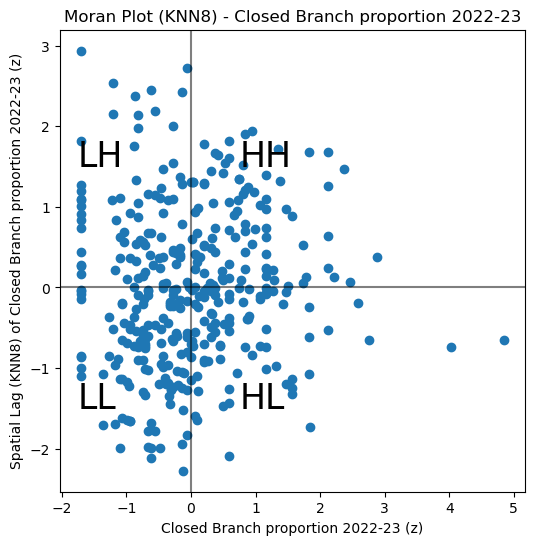

In [82]:
#create Moran plot

fig, ax2223 = plt.subplots(1, figsize=(6, 6))
# Plot values
plt.scatter(clbr_ladprop_2022_23['clbr_prop_z'], clbr_ladprop_2022_23['clbrprop_lag_z'])
# Add vertical and horizontal lines through zero
ax2223.axvline(0, c='k', alpha=0.5)
ax2223.axhline(0, c='k', alpha=0.5)
# Add text labels for each quadrant
plt.text(0.75, 1.5, "HH", fontsize=25)
plt.text(0.75, -1.5, "HL", fontsize=25)
plt.text(-1.75, 1.5, "LH", fontsize=25)
plt.text(-1.75, -1.5, "LL", fontsize=25)
# Display
ax2223.set_title('Moran Plot (KNN8) - Closed Branch proportion 2022-23')
ax2223.set_xlabel("Closed Branch proportion 2022-23 (z)")
ax2223.set_ylabel("Spatial Lag (KNN8) of Closed Branch proportion 2022-23 (z)")
plt.show()

In [83]:
#calculate Local Moran's I

lisa_clbrprop2223KNN8 = esda.moran.Moran_Local(clbr_ladprop_2022_23['clbr_prop'], clbr2223KNN8, seed=10)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

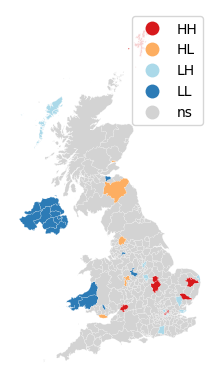

In [84]:
#cluster map - p=0.05

esdaplot.lisa_cluster(lisa_clbrprop2223KNN8, clbr_ladprop_2022_23, p=0.05)

In [85]:
#adjusting p-value threshold

lisa_clbrprop2223KNN8_fdr95 = esda.fdr(pvalues=lisa_clbrprop2223KNN8.p_sim, alpha=0.05)
lisa_clbrprop2223KNN8_fdr95

0.00013850415512465375

(<Figure size 640x480 with 1 Axes>, <Axes: >)

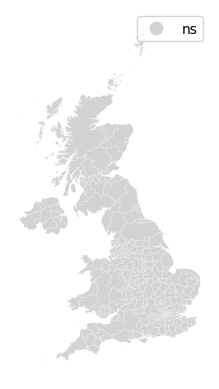

In [86]:
#cluster map with adjusted threshold
esdaplot.lisa_cluster(lisa_clbrprop2223KNN8, clbr_ladprop_2022_23, p=lisa_clbrprop2223KNN8_fdr95)

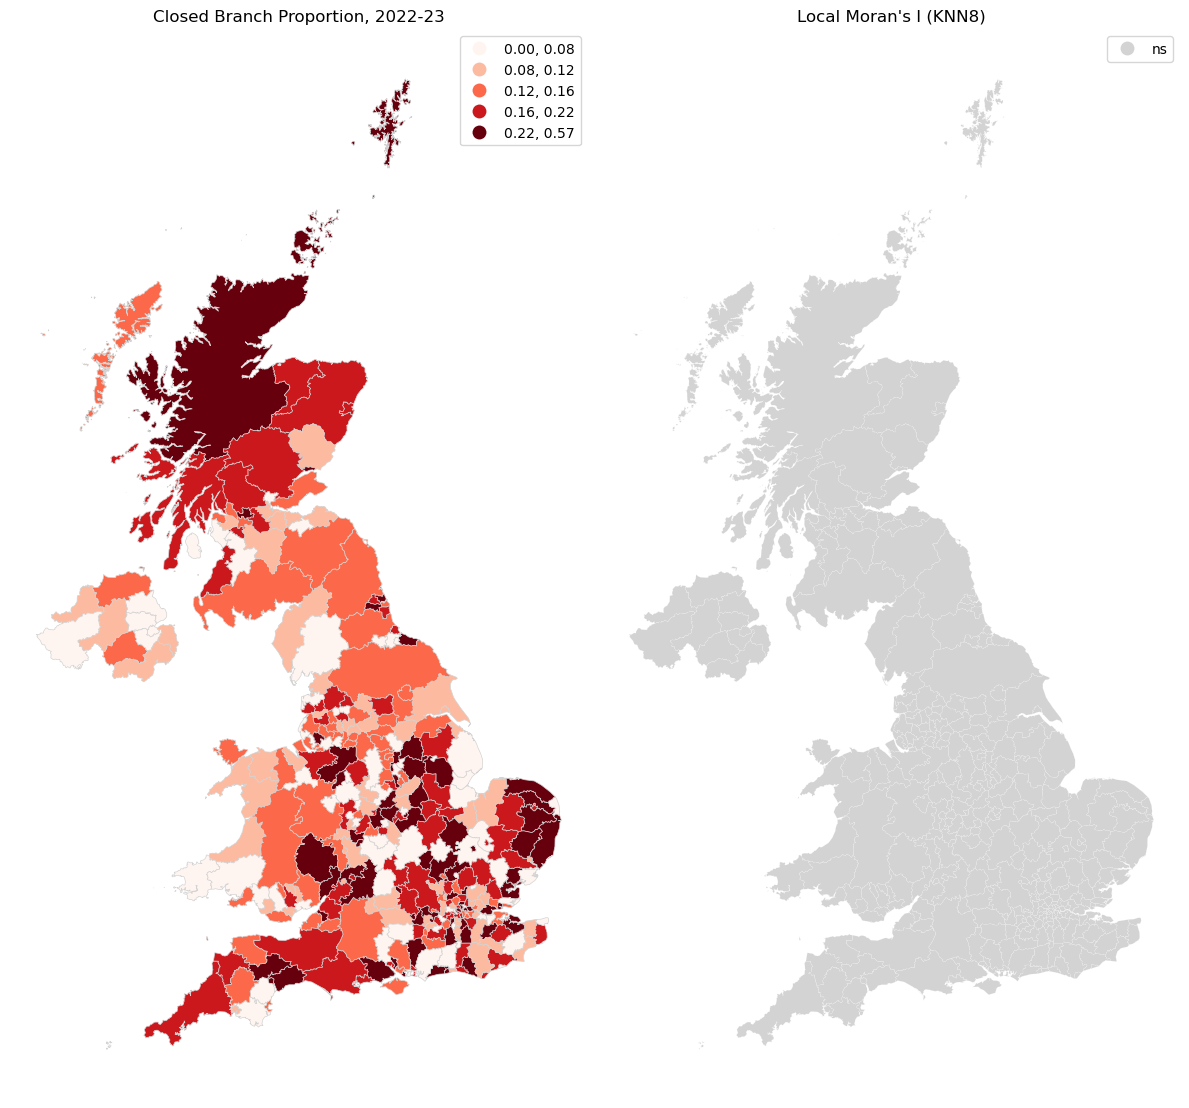

In [87]:
#your code here
fig, ax3 = plt.subplots(1,2, figsize=(12, 12))

clbr_ladprop_2022_23.plot(ax=ax3[0], column='clbr_prop', cmap='Reds', 
        scheme='quantiles', legend=True,
       edgecolor="lightgrey", linewidth=0.5)
ax3[0].set_axis_off()
ax3[0].set_title("Closed Branch Proportion, 2022-23")

esdaplot.lisa_cluster(lisa_clbrprop2223KNN8, clbr_ladprop_2022_23, p=lisa_clbrprop2223KNN8_fdr95, ax=ax3[1])

ax3[1].set_title("Local Moran's I (KNN8)")

fig.tight_layout()
plt.show()